In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.lines import Line2D
from sklearn.metrics import f1_score

# Исходные данные

In [3]:
PATH_TO_PROJECT: str = 'C:\\Users\\Mark\\PycharmProjects\\machineLearningNstu'
sys.path.append(PATH_TO_PROJECT)

PATH_TO_DIESEL: str = os.path.join(PATH_TO_PROJECT, 'data', 'raw', 'diesel_steam.csv')
PATH_TO_KEROSENE: str = os.path.join(PATH_TO_PROJECT, 'data', 'raw', 'kerosene_steam.csv')
PATH_TO_HEAVY_OIL: str = os.path.join(PATH_TO_PROJECT, 'data', 'raw', 'heavy_oil_steam.csv')
PATH_TO_CRUDE_OIL: str = os.path.join(PATH_TO_PROJECT, 'data', 'raw', 'crude_oil_steam.csv')
PATH_TO_WASTE_OIL: str = os.path.join(PATH_TO_PROJECT, 'data', 'raw', 'waste_oil_steam.csv')


diesel: pd.DataFrame = pd.read_csv(PATH_TO_DIESEL)
kerosene: pd.DataFrame = pd.read_csv(PATH_TO_KEROSENE)
heavy_oil: pd.DataFrame = pd.read_csv(PATH_TO_HEAVY_OIL)
crude_oil: pd.DataFrame = pd.read_csv(PATH_TO_CRUDE_OIL)
waste_oil: pd.DataFrame = pd.read_csv(PATH_TO_WASTE_OIL)

# Формирование входных параметров для обучения и предсказания модели

In [4]:
diesel_df: pd.DataFrame = pd.concat([diesel['NOx'], diesel['SO2']], axis=1)
diesel_df.loc[:, 'Type'] = 'diesel'

kerosene_df: pd.DataFrame = pd.concat([kerosene['NOx'], kerosene['SO2']], axis=1)
kerosene_df['Type'] = 'kerosene'

heavy_oil_df: pd.DataFrame = pd.concat([heavy_oil['NOx'], heavy_oil['SO2']], axis=1)
heavy_oil_df['Type'] = 'heavy_oil'

crude_oil_df: pd.DataFrame = pd.concat([crude_oil['NOx'], crude_oil['SO2']], axis=1)
crude_oil_df['Type'] = 'crude_oil'

waste_oil_df: pd.DataFrame = pd.concat([waste_oil['NOx'], waste_oil['SO2']], axis=1)
waste_oil_df['Type'] = 'waste_oil'

df: pd.DataFrame = pd.concat([diesel_df, kerosene_df, heavy_oil_df, crude_oil_df, waste_oil_df], axis=0)

training_sample_size: int = int(len(df) / 5)
training_sample: pd.DataFrame = df.sample(training_sample_size)

# График обучающей выборки

<Axes: xlabel='NOx', ylabel='SO2'>

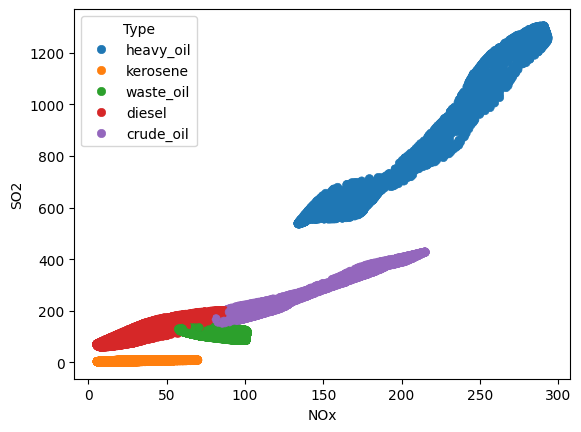

In [5]:
sns.scatterplot(data=training_sample, x='NOx', y='SO2', hue='Type', edgecolor=None)

# Обучение и проверка предсказывания модели

In [8]:
x_train: list[float, float] = [list(sample) for sample in zip(training_sample['NOx'], training_sample['SO2'])]
y_train: list[float] = list(training_sample['Type'])

x_test: list[float, float] = [list(sample) for sample in zip(df['NOx'], df['SO2'])]
y_test: list[float] = list(df['Type'])

rbf = svm.SVC(kernel='linear', gamma=0.5, C=0.1).fit(x_train, y_train)
rbf_pred = rbf.predict(x_test)

rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
rbf_f1

0.9834916385452571

# График с разделяющими гиперплоскостями и генеральной выборкой

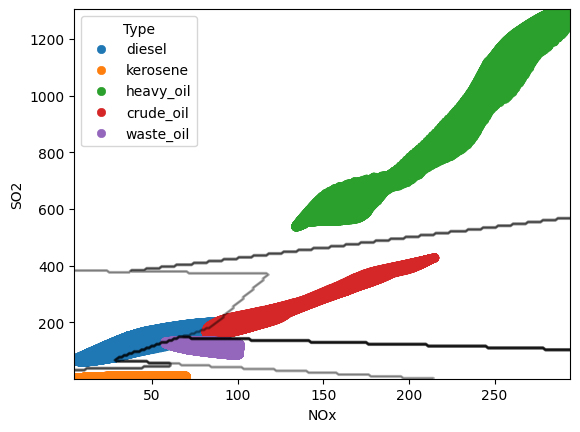

In [146]:
sns.scatterplot(data=df, x='NOx', y='SO2', hue='Type', edgecolor=None)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
        rbf,
        np.array(x_test),
        ax=ax,
        grid_resolution=200,
        plot_method="contour",
        colors="black",
        alpha=0.3,
    )